<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/docs-update/examples/tutorial_3_feedforward_snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - A Feedforward Spiking Neural Network
## Tutorial 3
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_3_feedforward_snn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction
In this tutorial, you will:
* Learn how to simplify the leaky integrate-and-fire (LIF) neuron to make it deep learning-friendly
* Implement a feedforward spiking neural network (SNN)

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

!pip install snntorch

In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. Simplifying the Leaky Integrate-and-Fire Neuron Model
In the previous tutorial, we designed our own LIF neuron model. But it was quite complex, and added an array of hyperparameters to tune, including $R$, $C$, $\Delta t$, $U_{\rm thr}$, and the choice of reset mechanism. This is a lot to keep track of, and only grows more cumbersome when scaled up to a full-blown SNN. So let's make a few simplfications. 


## 1.1 The Decay Rate: $\beta$

In the previous tutorial, the Euler method was used to derive the following solution to the passive membrane model:

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) + \frac{\Delta t}{\tau} I_{\rm in}(t)R \tag{1}$$

Now assume there is no input current, $I_{\rm in}(t)=0 A$:

$$U(t+\Delta t) = (1-\frac{\Delta t}{\tau})U(t) \tag{2}$$

Let the ratio of subsequent values of $U$, i.e., $U(t+\Delta t)/U(t)$ be the decay rate of the membrane potential, also known as the inverse time constant:

$$U(t+\Delta t) = \beta U(t) \tag{3}$$

From $(1)$, this implies that:

$$\beta = (1-\frac{\Delta t}{\tau}) \tag{4}$$

For reasonable accuracy, $\Delta t << \tau$.

## 1.2 Weighted Input Current
If we assume $t$ represents time-steps in a sequence rather than continuous time, then we can set $\Delta t = 1$. To further reduce the number of hyperparameters, assume $R=1$. From $(4)$, these assumptions lead to:

$$\beta = (1-\frac{1}{C}) \implies (1-\beta)I_{\rm in} = \frac{1}{\tau}I_{\rm in} \tag{5}$$

The input current is weighted by $(1-\beta)$. 
By additionally assuming input current instantaneously contributes to the membrane potential:

$$U[t+1] = \beta U[t] + (1-\beta)I_{\rm in}[t+1] \tag{6}$$

Note that the discretization of time means we are assuming that each time bin $t$ is brief enough such that a neuron may only emit a maximum of one spike in this interval.

In deep learning, the weighting factor of an input is often a learnable parameter. Taking a step away from the physically viable assumptions made thus far, we subsume the effect of $(1-\beta)$ from $(6)$ into a learnable weight $W$, and replace $I_{\rm in}[t]$ accordingly with an input $X[t]$:

$$WX[t] = I_{\rm in}[t] \tag{7}$$

This can be interpreted in the following way. $X[t]$ is an input voltage, or spike, and is scaled by the synaptic conductance of $W$ to generate a current injection to the neuron. This gives us the following result:

$$U[t+1] = \beta U[t] + WX[t+1] \tag{8}$$


In future simulations, the effects of $W$ and $\beta$ are decoupled.
$W$ is a learnable parameter that is updated independently of $\beta$.


## 1.3 Spiking and Reset
We now introduce the spiking and reset mechanisms. Recall that if the membrane exceeds the threshold, then the neuron emits an output spike: 

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{9}$$

If a spike is triggered, the membrane potential should be reset. The *reset-by-subtraction* mechanism is modeled by:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{S[t]U_{\rm thr}}_\text{reset} \tag{10}$$

As $W$ is a learnable parameter, and $U_{\rm thr}$ is often just set to $1$ (though can be tuned), this leaves the decay rate $\beta$ as the only hyperparameter left to be specified. This completes the painful part of this tutorial. 

> Note: some implementations might make slightly different assumptions. E.g., $S[t] \rightarrow S[t+1]$ in $(9)$, or $X[t] \rightarrow X[t+1]$ in $(10)$. This above derivation is what is used in snnTorch as we find it maps intuitively to a recurrent neural network representation, without any change in performance.

<font color = 'orange'>Notes : </font>

方程 U[t + 1] = βU[t] + (1-β)Iᵢₙ[t + 1] 表明：

- βU[t] 部分表示当前膜电位的衰减效应
- (1-β)Iᵢₙ[t + 1] 部分表示新输入电流的影响

## 1.4 Code Implementation
Implementing this neuron in Python looks like this:

In [3]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

> Note : 对比tut2的LIF完成代码
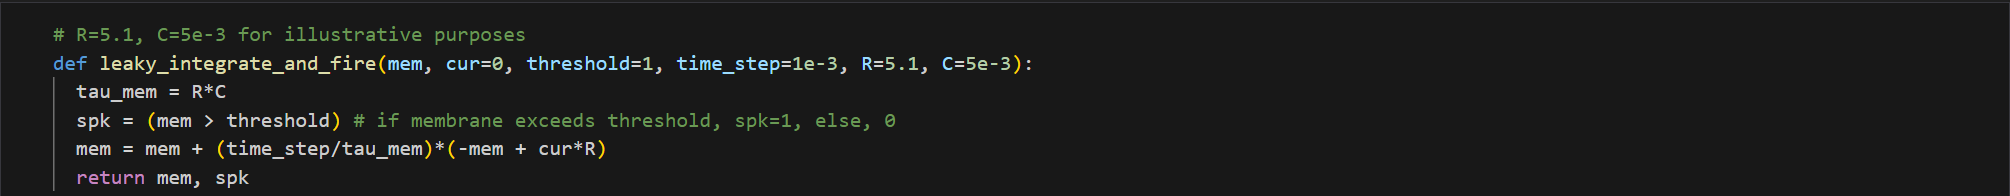

To set $\beta$, we have the option of either using Equation $(3)$ to define it, or hard-coding it directly. Here, we will use $(3)$ for the sake of a demonstration, but in future, it will just be hard-coded as we are more focused on something that works rather than biological precision.

Equation $(3)$ tells us that $\beta$ is the ratio of membrane potential across two subsequent time steps. Solve this using the continuous time-dependent form of the equation (assuming no current injection), which was derived in [Tutorial 2](https://snntorch.readthedocs.io/en/latest/tutorials/index.html):

$$U(t) = U_0e^{-\frac{t}{\tau}}$$

$U_0$ is the initial membrane potential at $t=0$. Assume the time-dependent equation is computed at discrete steps of $t, (t+\Delta t), (t+2\Delta t)~...~$, then we can find the ratio of membrane potential between subsequent steps using:

$$\beta = \frac{U_0e^{-\frac{t+\Delta t}{\tau}}}{U_0e^{-\frac{t}{\tau}}} = \frac{U_0e^{-\frac{t + 2\Delta t}{\tau}}}{U_0e^{-\frac{t+\Delta t}{\tau}}} =~~...$$
$$\implies \beta = e^{-\frac{\Delta t}{\tau}} $$


In [4]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

The decay rate is: 0.819


Run a quick simulation to check the neuron behaves correctly in response to a step voltage input:

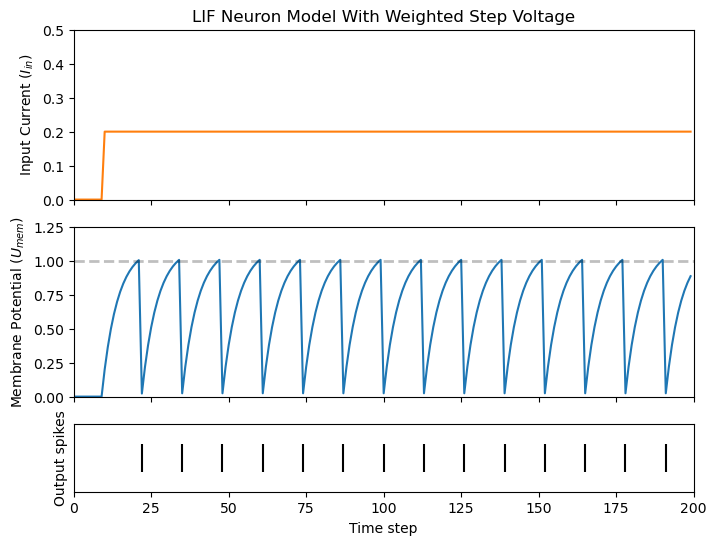

In [5]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

# 2. `Leaky` Neuron Model in snnTorch

An almost identical neuron can be achieved by instantiating `snn.Leaky`, in a similar way to how we used `snn.Lapicque` in the previous tutorial. But with less hyperparameters:



In [6]:
lif1 = snn.Leaky(beta=0.8)

The neuron model is now stored in `lif1`. To use this neuron:

**Inputs**
* `cur_in`: each element of $W\times X[t]$ is sequentially passed as an input
* `mem`: the previous step membrane potential, $U[t-1]$, is also passed as input.

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U[t]$ of the present step

These all need to be of type `torch.Tensor`. Note that here, we assume the input current has already been weighted before passing into the `snn.Leaky` neuron. This will make more sense when we construct a network-scale model. Also, equation $(10)$ has been time-shifted back one step without loss of generality.


In [ ]:
# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

Compare this plot with the manually derived leaky integrate-and-fire neuron. The membrane potential reset is slightly weaker: i.e., it uses a *soft reset*. This has been done intentionally because it enables better performance on a few deep learning benchmarks. The equation used instead is:

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{\beta S[t]U_{\rm thr}}_\text{soft reset} \tag{11}$$


This model has the same optional input arguments of `reset_mechanism` and `threshold` as described for Lapicque's neuron model.

<font color="orange"> Note :  </font>
S(t)是spike function

S[t] = 
-     1, if U[t] > Uₜₕᵣ  (当膜电位超过阈值)
-     0, otherwise       (其他情况)


# 3. A Feedforward Spiking Neural Network

So far, we have only considered how a single neuron responds to input stimulus. snnTorch makes it straightforward to scale this up to a deep neural network. In this section, we will create a 3-layer fully-connected neural network of dimensions 784-1000-10. Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes. 


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

PyTorch is used to form the connections between neurons, and snnTorch to create the neurons. First, initialize all layers.

In [7]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

Next, initialize the hidden variables and outputs of each spiking neuron. 
As networks increase in size, this becomes more tedious. The static method `init_leaky()` can be used to take care of this. All neurons in snnTorch have their own initialization methods that follow this same syntax, e.g., `init_lapicque()`. The shape of the hidden states are automatically initialized based on the input data dimensions during the first forward pass. 

In [8]:
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

Create an input spike train to pass to the network. There are 200 time steps to simulate across 784 input neurons, i.e., the input originally has dimensions of $200 \times 784$. However, neural nets typically process data in minibatches. snnTorch uses time-first dimensionality: 

[$time \times batch\_size \times feature\_dimensions$]

So 'unsqueeze' the input along `dim=1` to indicate 'one batch' of data. The dimensions of this input tensor must be 200 $\times$ 1 $\times$ 784:

In [9]:
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


Now it's finally time to run a full simulation. 
An intuitive way to think about how PyTorch and snnTorch work together is that PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like time-varying activation functions.

Here is a sequential account of what's going on:

*  The $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $X_{i} \times W_{ij}$
* This generates the input current term from Equation $(10)$, contributing to $U[t+1]$ of the spiking neuron
* If $U[t+1] > U_{\rm thr}$, then a spike is triggered from this neuron
* This spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons.
* If there is no spike, then nothing is passed to the post-synaptic neuron.

The only difference from our simulations thus far is that we are now scaling the input current with a weight generated by `nn.Linear`, rather than manually setting $W$ ourselves.

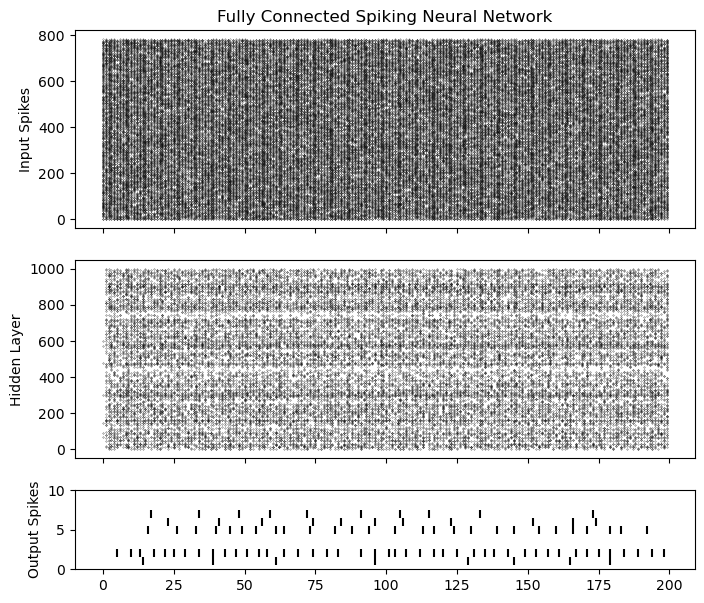

In [10]:
# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> If you run into errors, then try re-initializing your networks and parameters.


At this stage, the spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But the spikes  should appear to be propagating from the first layer through to the output. If you are not seeing any spikes, then you might have been unlucky in the weight initialization lottery - you might want to try re-running the last four code-blocks. 

`spikeplot.spike_count` can create a spike counter of the output layer. The following animation will take some time to generate. <br>

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



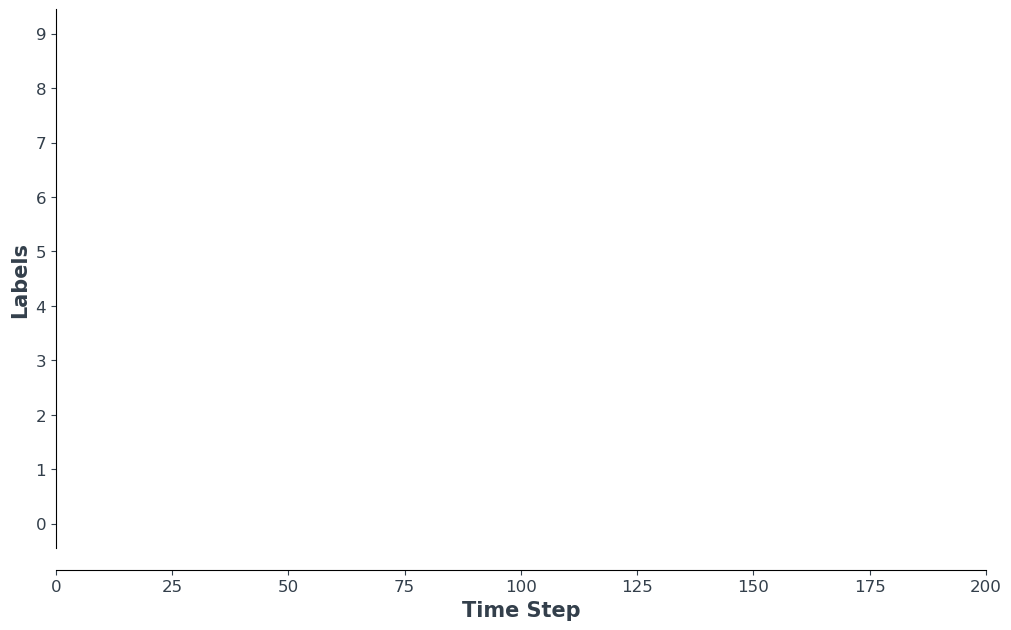

In [11]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces` lets you visualize the membrane potential traces. We will plot 9 out of 10 output neurons. 
Compare it to the animation and raster plot above to see if you can match the traces to the neuron. 

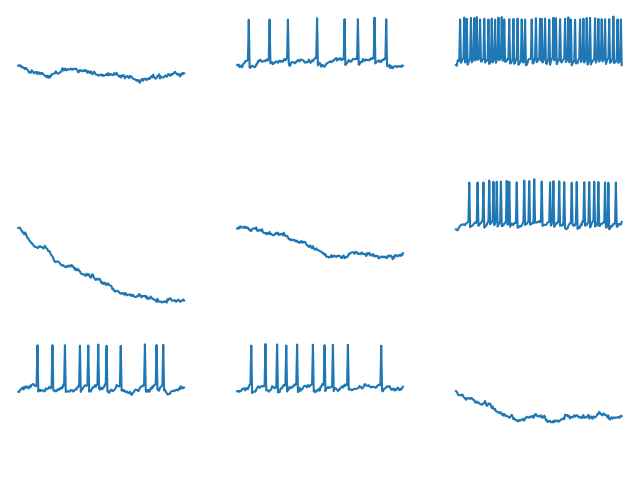

In [12]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)

It is fairly normal if some neurons are firing while others are completely dead. Again, none of these spikes have any real meaning until the weights have been trained.

# Conclusion

That covers how to simplify the leaky integrate-and-fire neuron model, and then using it to build a spiking neural network. In practice, we will almost always prefer to use `snn.Leaky` over `snn.Lapicque` for training networks, as there is a smaller hyperparameter search space. 

[Tutorial 4](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) goes into detail with the 2nd-order `snn.Synaptic` and `snn.Alpha` models.
This next tutorials is not necessary for training a network, so if you wish to go straight to deep learning with snnTorch, then skip ahead to [Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

For reference, the documentation [can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.html).

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.

## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan